# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [14]:
df = pd.read_csv('../data/checker_submits.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.weekday
df = df.reset_index()[["uid", "labname", "numTrials", "hour", "dayofweek"]]

In [15]:
cat_cols = ["uid", "labname"]
num_cols = ["numTrials", "hour"]
target_col = "dayofweek"

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_cat = ohe.fit_transform(df[cat_cols])
cat_feature_names = ohe.get_feature_names_out(cat_cols)

df_cat = pd.DataFrame(X_cat, columns=cat_feature_names, index=df.index)

scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

df_num = pd.DataFrame(
    X_num,
    columns=[f"{c}_scaled" for c in num_cols],
    index=df.index
)

dayofweek_df = pd.concat([df_cat, df_num, df[[target_col]]], axis=1)

dayofweek_df.to_csv("../data/dayofweek.csv", index=False)

most_popular = dayofweek_df[target_col].mode()[0]
naive_accuracy = (dayofweek_df[target_col] == most_popular).mean()

print(naive_accuracy)

0.23487544483985764


## 2. Algorithms

In [16]:
def plot_top_features_barh(coef, feature_names, top_n=10, title=None):
    try:
        coef_matrix = np.vstack([est.coef_.ravel() for est in coef.estimators_])
        importance = np.abs(coef_matrix).sum(axis=0)
    except:
        coef = np.asarray(coef)
        if coef.ndim == 2:
            importance = np.abs(coef).sum(axis=0)
        else:
            importance = np.abs(coef)

    top_idx = np.argsort(importance)[-top_n:]
    top_names = np.array(feature_names)[top_idx]
    top_vals = importance[top_idx]
    plt.figure(figsize=(10, 6))
    plt.barh(top_names, top_vals)
    plt.xlabel("Feature importance")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

0.6405693950177936


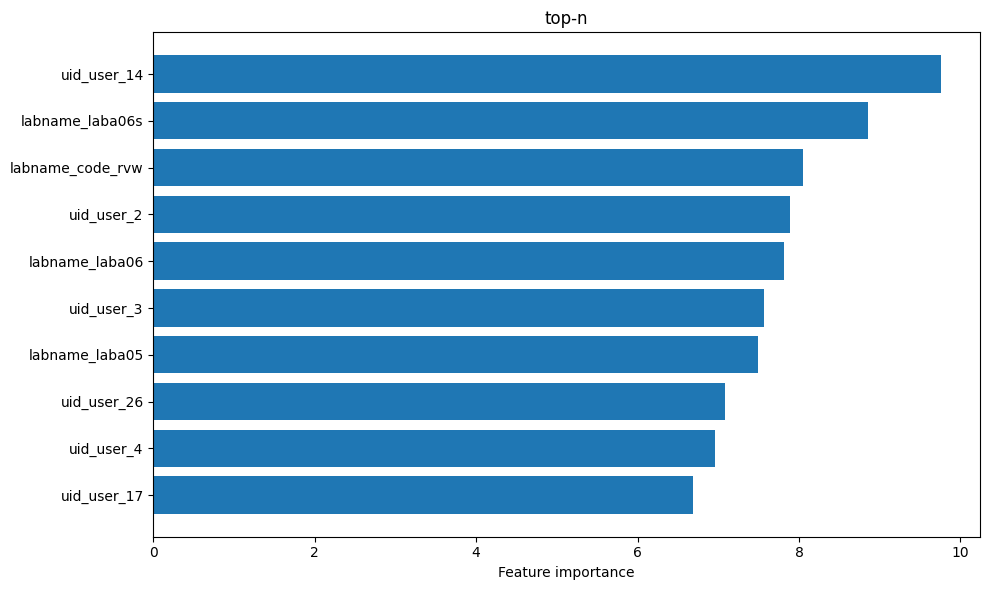

In [17]:
X = dayofweek_df.drop(columns=[target_col])
y = dayofweek_df[target_col]

lr = LogisticRegression(random_state=21, fit_intercept=False)

lr.fit(X, y)
y_pred = lr.predict(X)
acc = accuracy_score(y, y_pred)
print(acc)

plot_top_features_barh(
    lr.coef_,
    X.columns,
    top_n=10,
    title='top-n',
)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [18]:
#"linear", "rbf", "poly", "sigmoid"
svc_linear = SVC(kernel="linear", probability=True, random_state=21)

ovr_linear = OneVsRestClassifier(svc_linear)

ovr_linear.fit(X, y)
pred = ovr_linear.predict(X)

print(accuracy_score(y, pred))

0.6120996441281139


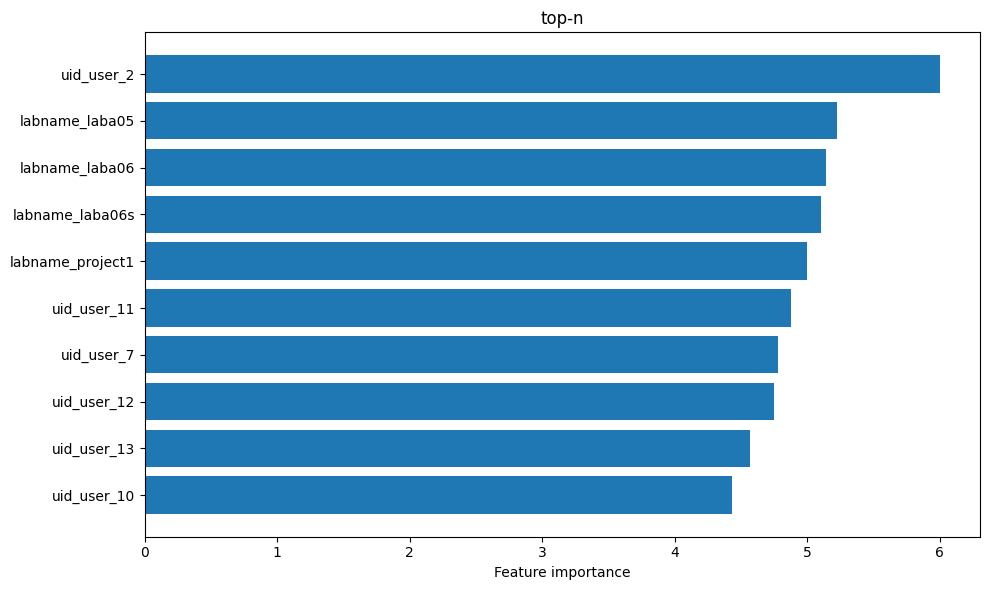

In [19]:
plot_top_features_barh(
    ovr_linear,
    X.columns,
    top_n=10,
    title='top-n',
)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [20]:
dt_base = DecisionTreeClassifier(max_depth=4, random_state=21)
dt_base.fit(X, y)

pred = dt_base.predict(X)
print(accuracy_score(y, pred))

0.5516014234875445


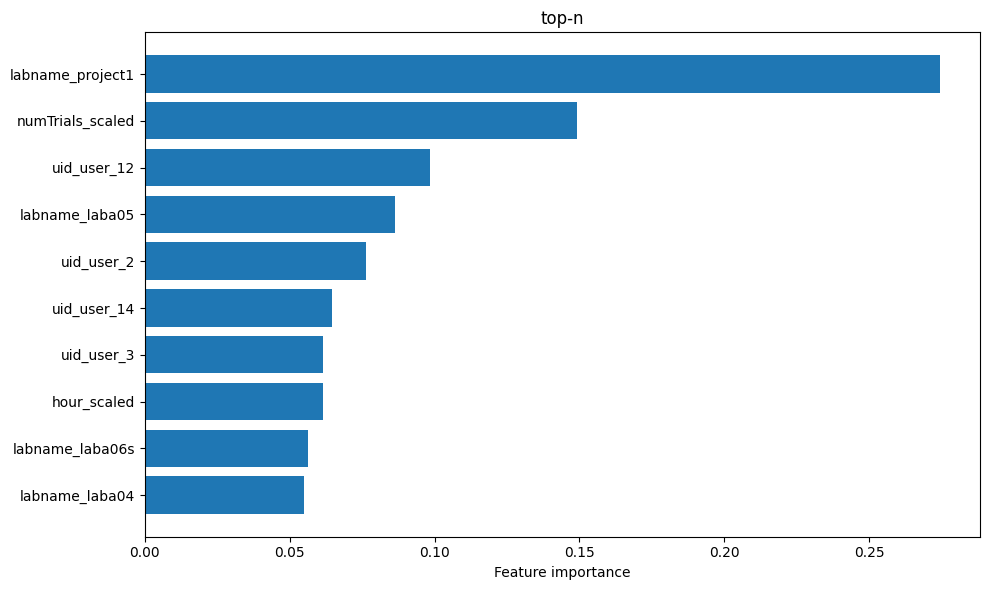

In [21]:
plot_top_features_barh(
    dt_base.feature_importances_,
    X.columns,
    top_n=10,
    title='top-n',
)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [22]:
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    random_state=21,
)

rf_base.fit(X, y)
pred = rf_base.predict(X)

print(accuracy_score(y, pred))

0.9988137603795967


In [23]:
depths = [5, 10, 15, 25, None]
n_estimators_list = [50, 100, 200]

results = []
for d in depths:
    for n_est in n_estimators_list:
        rf = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=d,
            random_state=21,
            n_jobs=-1
        )
        rf.fit(X, y)
        pred = rf.predict(X)
        acc = accuracy_score(y, pred)
        results.append((d, n_est, acc))

for d, n_est, acc in sorted(results, key=lambda x: -x[2]):
    print(f"max_depth={d}, n_estimators={n_est} -> {acc}")


max_depth=25, n_estimators=200 -> 1.0
max_depth=None, n_estimators=50 -> 1.0
max_depth=None, n_estimators=100 -> 1.0
max_depth=None, n_estimators=200 -> 1.0
max_depth=25, n_estimators=50 -> 0.9994068801897983
max_depth=25, n_estimators=100 -> 0.9988137603795967
max_depth=15, n_estimators=100 -> 0.9804270462633452
max_depth=15, n_estimators=200 -> 0.9804270462633452
max_depth=15, n_estimators=50 -> 0.9798339264531435
max_depth=10, n_estimators=50 -> 0.8795966785290629
max_depth=10, n_estimators=100 -> 0.8701067615658363
max_depth=10, n_estimators=200 -> 0.8701067615658363
max_depth=5, n_estimators=100 -> 0.6429418742586003
max_depth=5, n_estimators=200 -> 0.6239620403321471
max_depth=5, n_estimators=50 -> 0.6198102016607354


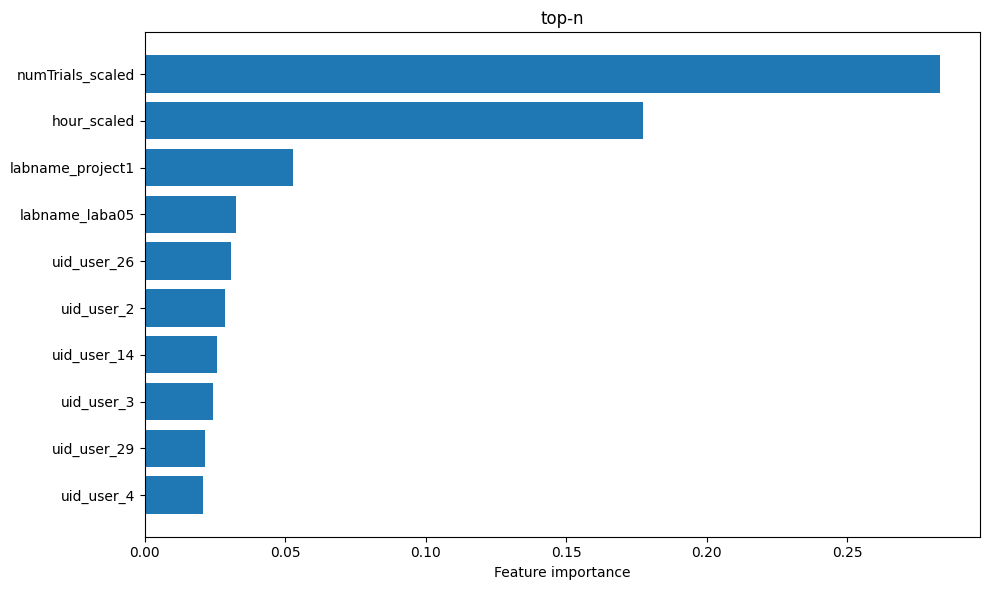

In [24]:
plot_top_features_barh(
    rf_base.feature_importances_,
    X.columns,
    top_n=10,
    title='top-n',
)